<h2 style="text-align:center;font-size:200%;;">Predicting Road Accident Risk

In [1]:
from IPython.display import display, HTML

display(HTML("""
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ABUALHUSSEIN/predicting-road-accident-risk-kaggle/refs/heads/main/road.png" width="1000">
</div>
"""))

## Table of Contents<a id='top'></a>
>1. [Overview](#1.-Overview)  
>    * [Project Detail](#Project-Detail)
>    * [Goal of this notebook](#Goal-of-this-notebook)
>1. [Import libraries](#2.-Import-libraries)
>1. [Load the dataset](#3.-Load-the-dataset)
>1. [EDA](#4.-EDA)  
>1. [Modeling](#5.-Modeling)
>1. [Conclusion](#6.-Conclusion)
>    * [Task Submission](#Task-Submission)


# 1. Overview
## Project Detail
>In The primary goal is to build a robust machine learning model that accurately predicts the continuous accident_risk score for a given road segment. This is a regression task. A successful model could help identify high-risk areas, enabling proactive safety interventions and better resource allocation.<br/>
></ul>

## Goal of this notebook
>* Practice EDA technique
>* Practice visualising technique
>* Practice modeling technique
>    * LightGBM(+ plotting the tree)
>* Causal analysis skill

# 2. Import libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings("ignore")

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 3. Load the dataset

In [4]:

train  = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")  

In [5]:
# Quick look
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
print("Shape of dataset:", train.shape)

Shape of dataset: (517754, 14)


👉 Observation:

The dataset consists of 517754 observations and 14 features.



# 4. EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [8]:
# Let's identify the categorical columns you mentioned
categorical_features = ['road_type', 'lighting', 'weather', 'time_of_day']

In [9]:
print("--- Checking Levels of Categorical Features ---")
for col in categorical_features:
    num_levels = train[col].nunique()  # Get the number of unique levels
    levels = train[col].unique()      # Get the actual unique levels
    
    print(f"\nFeature: '{col}'")
    print(f"  Number of unique levels: {num_levels}")
    print(f"  Levels: {levels}")
    print("-" * 30)

--- Checking Levels of Categorical Features ---

Feature: 'road_type'
  Number of unique levels: 3
  Levels: ['urban' 'rural' 'highway']
------------------------------

Feature: 'lighting'
  Number of unique levels: 3
  Levels: ['daylight' 'dim' 'night']
------------------------------

Feature: 'weather'
  Number of unique levels: 3
  Levels: ['rainy' 'clear' 'foggy']
------------------------------

Feature: 'time_of_day'
  Number of unique levels: 3
  Levels: ['afternoon' 'evening' 'morning']
------------------------------


In [10]:
train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [12]:
# Missing values
print("Missing Values:", train.isnull().sum())

Missing Values: id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


In [13]:
#Duplicate rows
print("Duplicate rows:", train.duplicated().sum())

Duplicate rows: 0


👉 Observation:

The dataset was examined for data quality issues. No missing values were detected across all variables, and no duplicate rows were identified.

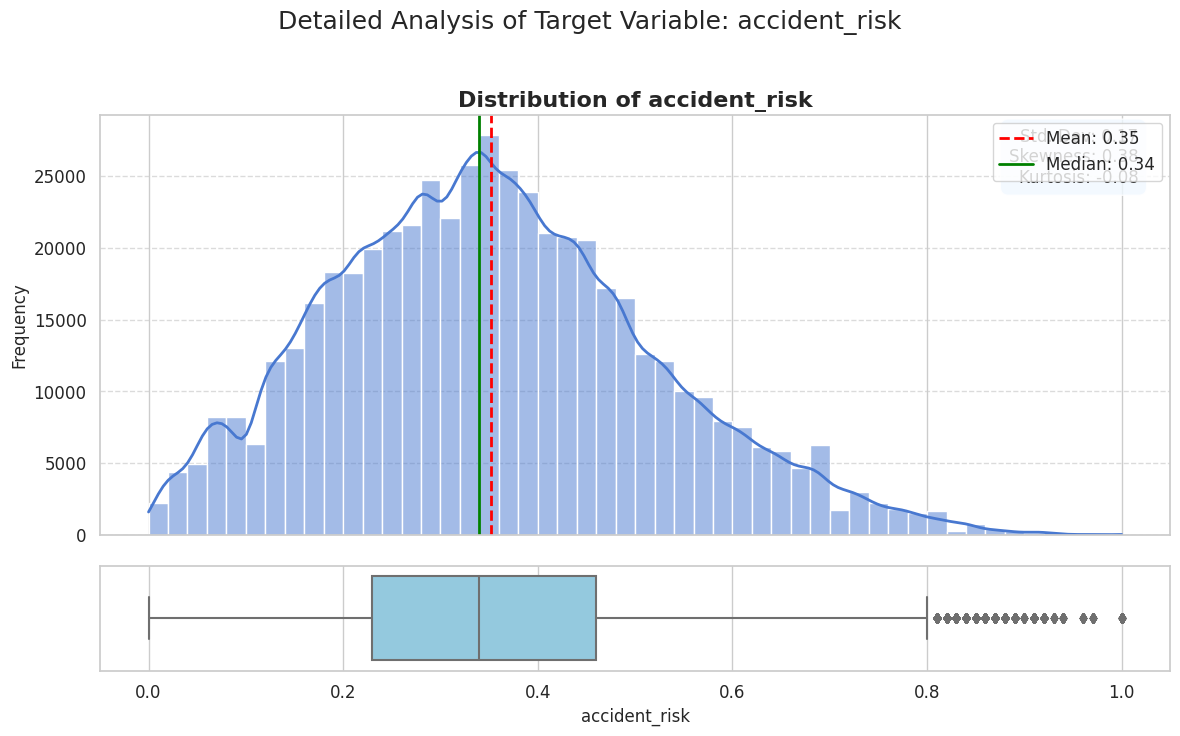

In [14]:

target = "accident_risk"

def plot_target_distribution(train, target, bins=50):
    """
    Generates a comprehensive plot for analyzing a regression target variable.
    
    The plot includes a histogram, KDE, boxplot, and key statistical annotations.
    
    Parameters:
    - train (pd.DataFrame): The input dataframe.
    - target (str): The name of the target column.
    - bins (int): The number of bins for the histogram.
    """
    # --- Calculate Statistics ---
    mean_val = train[target].mean()
    
    median_val = train[target].median()
    std_val = train[target].std()
    skew_val = train[target].skew()
    kurt_val = train[target].kurt()

    # --- Create the plot ---
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, 
        gridspec_kw={'height_ratios': (0.8, 0.2)}
    )
    
    # --- Histogram and KDE (Top Plot) ---
    sns.histplot(train[target], ax=ax_hist, kde=True, bins=bins, line_kws={'linewidth': 2})
    
    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax_hist.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    
    ax_hist.set_title(f'Distribution of {target}', fontsize=16, weight='bold')
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.legend(loc='upper right')
    ax_hist.grid(axis='y', linestyle='--', alpha=0.7)
    ax_hist.set_xlabel('')  # Hide x-label for the top plot

    # --- Statistical Annotations ---
    stats_text = (
        f"Std. Dev: {std_val:.2f}\n"
        f"Skewness: {skew_val:.2f}\n"
        f"Kurtosis: {kurt_val:.2f}"
    )
    ax_hist.text(0.97, 0.97, stats_text, transform=ax_hist.transAxes, fontsize=12,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    # --- Boxplot (Bottom Plot) ---
    sns.boxplot(x=train[target], ax=ax_box, color='skyblue')
    ax_box.set_xlabel(target, fontsize=12)
    ax_box.set_ylabel(' ', fontsize=12)

    # --- Final Touches ---
    plt.suptitle(f'Detailed Analysis of Target Variable: {target}', fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()
plot_target_distribution(train, target)


### In-Depth Analysis of the `accident_risk` Distribution

The histogram and box plot above provide a comprehensive view of our target variable, `accident_risk`.

**Key Observations:**

1.  **Unimodal Distribution:** The distribution has a single peak (unimodal), indicating a clear central tendency. The highest frequency of accidents occurs at a risk level of approximately 0.3 to 0.4.

2.  **Slight Positive Skew:** The mean (0.35) is slightly higher than the median (0.34). This indicates a slight positive, or right-skewed, distribution. This is visually confirmed by the longer tail extending towards the higher risk values on the right side of the histogram.

3.  **Presence of High-Risk Outliers:** The box plot clearly visualizes the data's spread and identifies numerous outliers. These points, primarily located above a risk value of ~0.75, represent road segments with exceptionally high accident risk compared to the majority of the data. These are likely the most critical cases for our model to predict accurately.

**Implications for Modeling:**

*   The distribution is close enough to normal that transformations (like a log transform) are likely unnecessary, especially for tree-based models (e.g., LightGBM, XGBoost) which are robust to non-normal distributions.
*   The outliers represent valid, high-risk scenarios and should not be removed. They are crucial for training a model that can identify dangerous conditions.

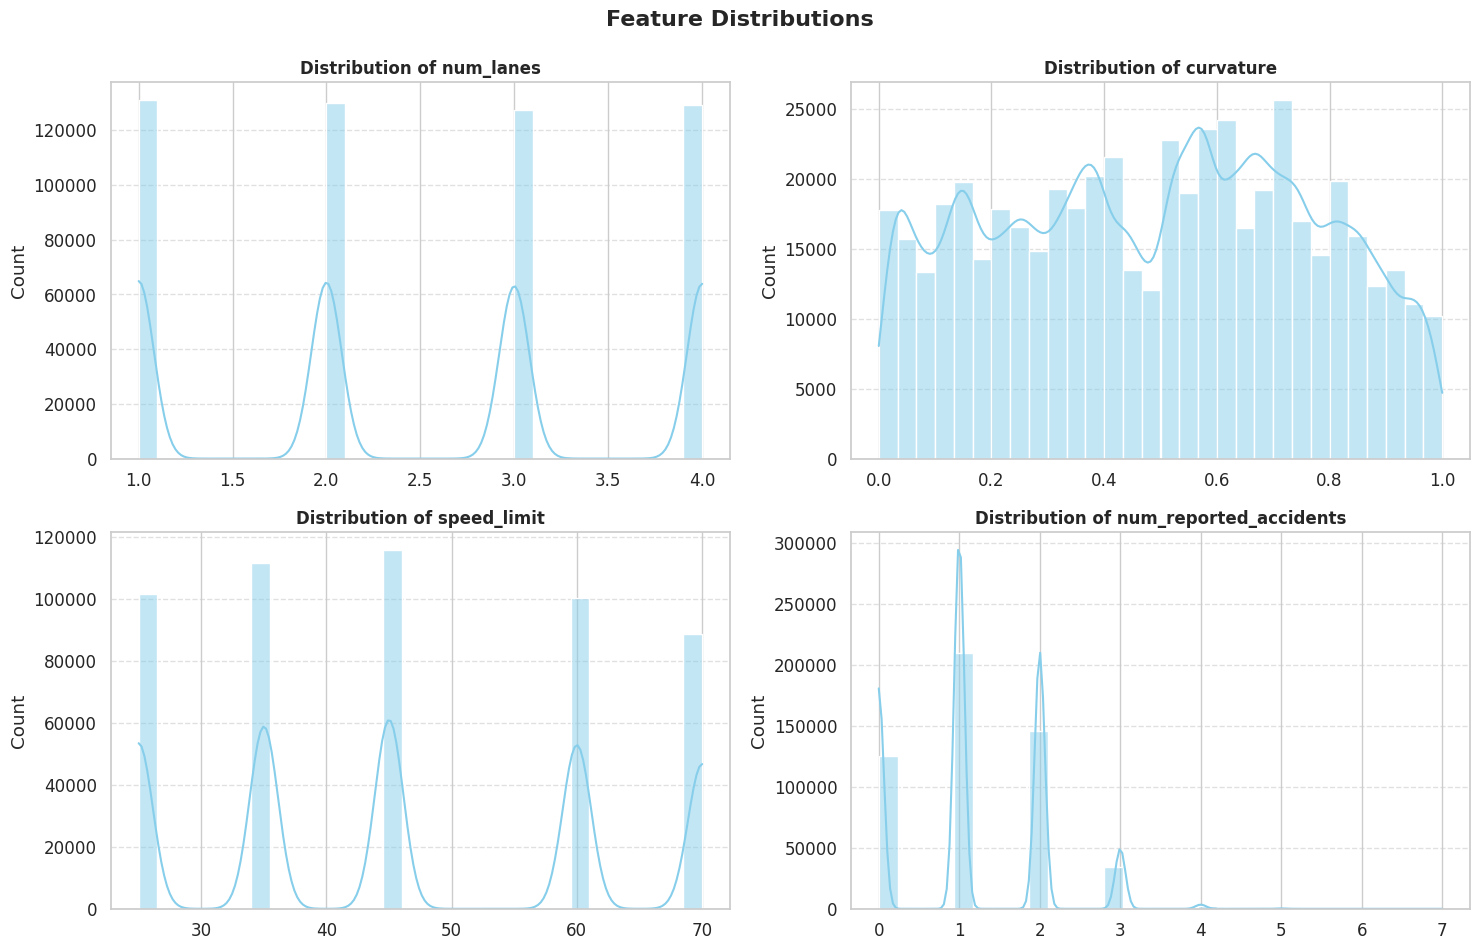

In [15]:
# ========================
# 4. Feature Distributions
# ========================


# Select numeric features (excluding ID if present)
num_features = train.select_dtypes(include=[np.number]).columns.tolist()
# Columns to exclude
exclude_cols = ["id","accident_risk"]
num_features = [col for col in num_features if col not in exclude_cols]

# Define grid size automatically (rows & cols)

n_features = len(num_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(num_features):
    sns.histplot(train[col], bins=30, kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution of {col}", fontsize=12, weight="bold")
    axes[i].set_xlabel("")
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

# Remove empty subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions", fontsize=16, weight="bold", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The histograms below show the distributions for our key numerical features.

This analysis helps us understand their nature (discrete vs. continuous), their spread, and identify any potential issues.
Key Observations:

👉Distribution of num_lanes:

Observation: The plot shows distinct, sharp peaks at integer values (1, 2, 3, and 4).

Interpretation: This confirms that num_lanes is a discrete numerical feature, not a continuous one. It represents a count. Four-lane and one-lane roads appear to be the most common in the dataset.

Action: It can be treated as a numerical feature. Standard scaling will be applied during preprocessing.

👉Distribution of curvature:

Observation: This feature has a continuous distribution, ranging from 0.0 to 1.0. The distribution is multi-modal (has several peaks) and does not follow a simple bell curve.

Interpretation: This suggests there is a wide variety of road curvatures in the dataset, with some common curvature levels appearing more frequently. A value of 0 likely represents a straight road.

Action: As a standard continuous feature, it will be scaled. Its complex shape suggests non-linear relationships with the target, which tree-based models like LightGBM can capture well.

👉Distribution of speed_limit:

Observation: Similar to num_lanes, this plot has sharp peaks at specific values (e.g., 30, 40, 50, 60, 70).
Interpretation: This is another discrete numerical feature, representing standard speed limits. The most common speed limits appear to be 30, 50, and 60.

Action: This will be treated as a numerical feature and scaled.

👉Distribution of num_reported_accidents:

Observation: The distribution is extremely right-skewed. The vast majority of data points are concentrated at low integer values (0, 1, 2), with a massive peak at 1. The frequency drops off dramatically for higher counts.

Interpretation & CRITICAL WARNING ⚠️: This feature is a direct count of accidents. It is highly probable that our target variable, accident_risk, is directly calculated or heavily influenced by this value. Including num_reported_accidents in our model would constitute data leakage. The model would simply learn to associate high accident counts with high risk, which is tautological and not predictive for new, unseen road segments.
Action: This feature must be dropped from the training data to build a meaningful and generalizable predictive model.


👉Summary Conclusion:
The features num_lanes, curvature, and speed_limit provide useful information and are ready for preprocessing (scaling). The feature num_reported_accidents represents a data leakage risk and will be excluded from the model.
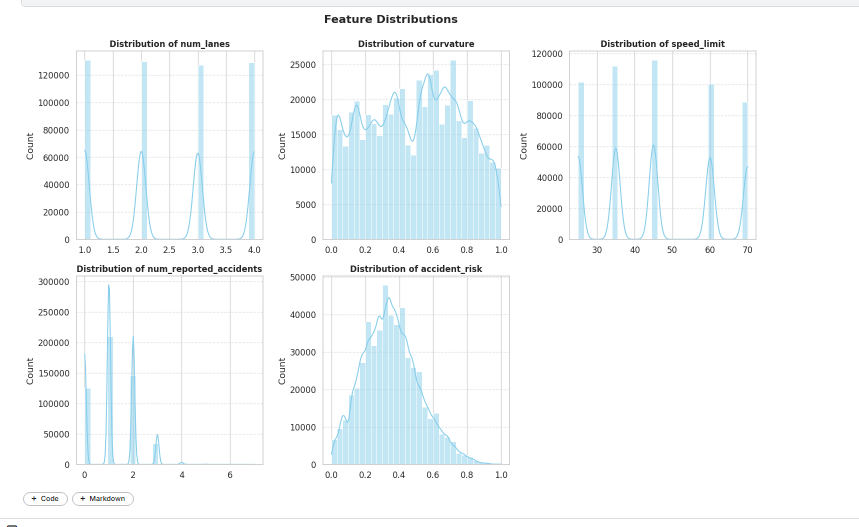

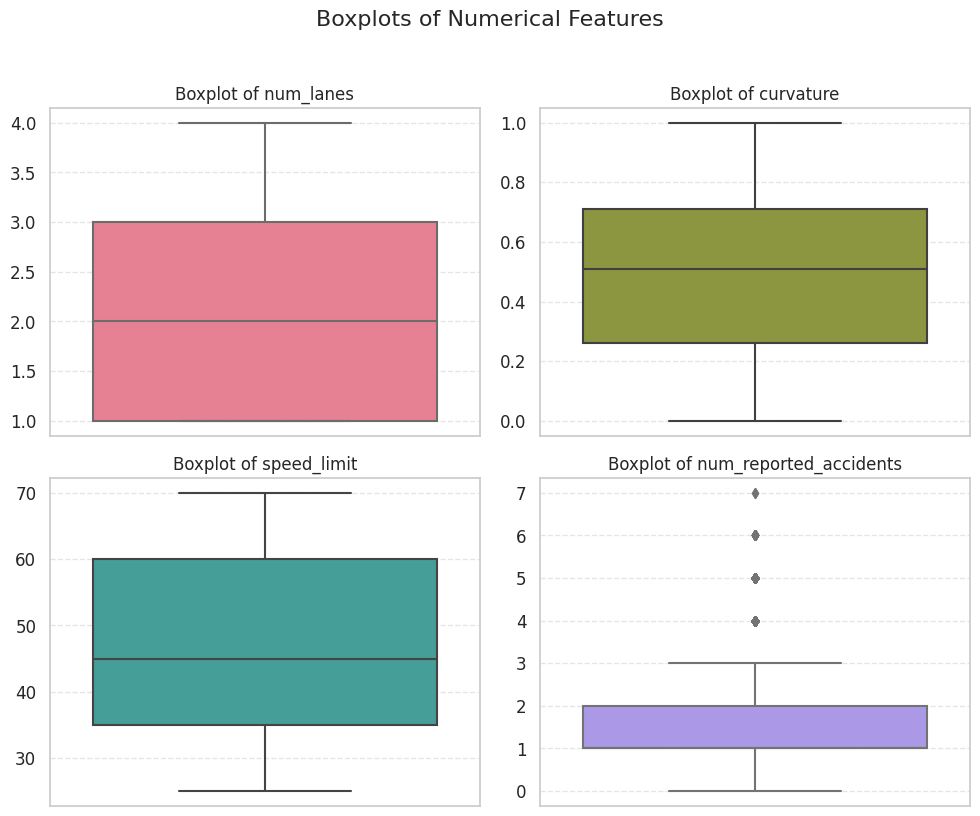

In [16]:

# Select numeric columns, excluding 'id' if present

num_features = train.select_dtypes(include=[np.number]).columns.tolist()
# Columns to exclude
exclude_cols = ["id","accident_risk"]
numerical_cols  = [col for col in num_features if col not in exclude_cols]

# Define color palette
palette = sns.color_palette("husl", len(numerical_cols))

# Grid layout: e.g., 4 columns
ncols = 2
nrows = -(-len(numerical_cols) // ncols)  # ceiling division

plt.figure(figsize=(5*ncols, 4*nrows))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(y=train[col], color=palette[i-1], showfliers=True, whis=1.5)
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Boxplots of Numerical Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Boxplot Analysis of Numerical Features

To further understand the distribution and spread of our numerical features, we can use boxplots. Boxplots are particularly effective at summarizing the five-number summary (minimum, first quartile, median, third quartile, maximum) and identifying outliers.

#### Observations from the Plots:

👉Boxplot of num_lanes:
Median: The median number of lanes is 2.
IQR: The central 50% of the data lies between 1 and 3 lanes.
Outliers: There are no outliers, as the data is discrete and falls within a small, expected range (1 to 4 lanes).

👉Boxplot of curvature:
Median: The median curvature is slightly above 0.5, indicating that half of the road segments have a relatively high degree of curvature.
IQR: The interquartile range is wide, spanning from approximately 0.25 to 0.7, which shows a significant variation in road curvature across the dataset.
Outliers: No outliers are present, suggesting the curvature values are well-contained within the 0.0 to 1.0 scale.

👉Boxplot of speed_limit:
Median: The median speed limit is around 45.
IQR: The middle 50% of speed limits range from roughly 35 to 60.
Outliers: Similar to num_lanes, there are no outliers, which is expected for a feature with standard, discrete values.

👉Boxplot of num_reported_accidents:
Median: The median is 1, which is a powerful insight. It means at least 50% of the road segments have 1 or fewer reported accidents.
IQR: The box is very narrow, with the 25th percentile at 1 and the 75th percentile at 2. This shows that the vast majority of the data is tightly clustered at very low accident counts.
Outliers: This plot is the only one with clear outliers. Values of 4 and above are flagged as outliers, which perfectly illustrates the extreme right-skew we saw in the histogram.
Key Takeaways & Confirmation:

The boxplots for num_lanes, curvature, and speed_limit show that these features are well-behaved, with no extreme or unexpected outlier values.

The boxplot for num_reported_accidents provides strong visual confirmation of our decision to drop this feature. Its distribution is fundamentally different from the others, and its outlier structure reinforces the idea that it's more of a direct component of the target than an independent predictor. Including it would risk data leakage.


In [17]:
# ====================================================
# 6. Correlation with Target Variable(Visualized)
# ====================================================

# Assuming 'target_col' is the name of your target variable string
target_col = 'accident_risk' # Replace with your actual target name

# We can reuse the corr_matrix from before
if 'corr_matrix' not in locals():
    corr_matrix = train[num_features].corr()

# Get correlations with the target, drop the target's self-correlation, and sort
target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
# You can still print the sorted values for exact numbers
print(f"\n--- Correlation with {target_col} ---")
print(target_corr)


--- Correlation with accident_risk ---
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
id                        0.000969
num_lanes                -0.006003
Name: accident_risk, dtype: float64


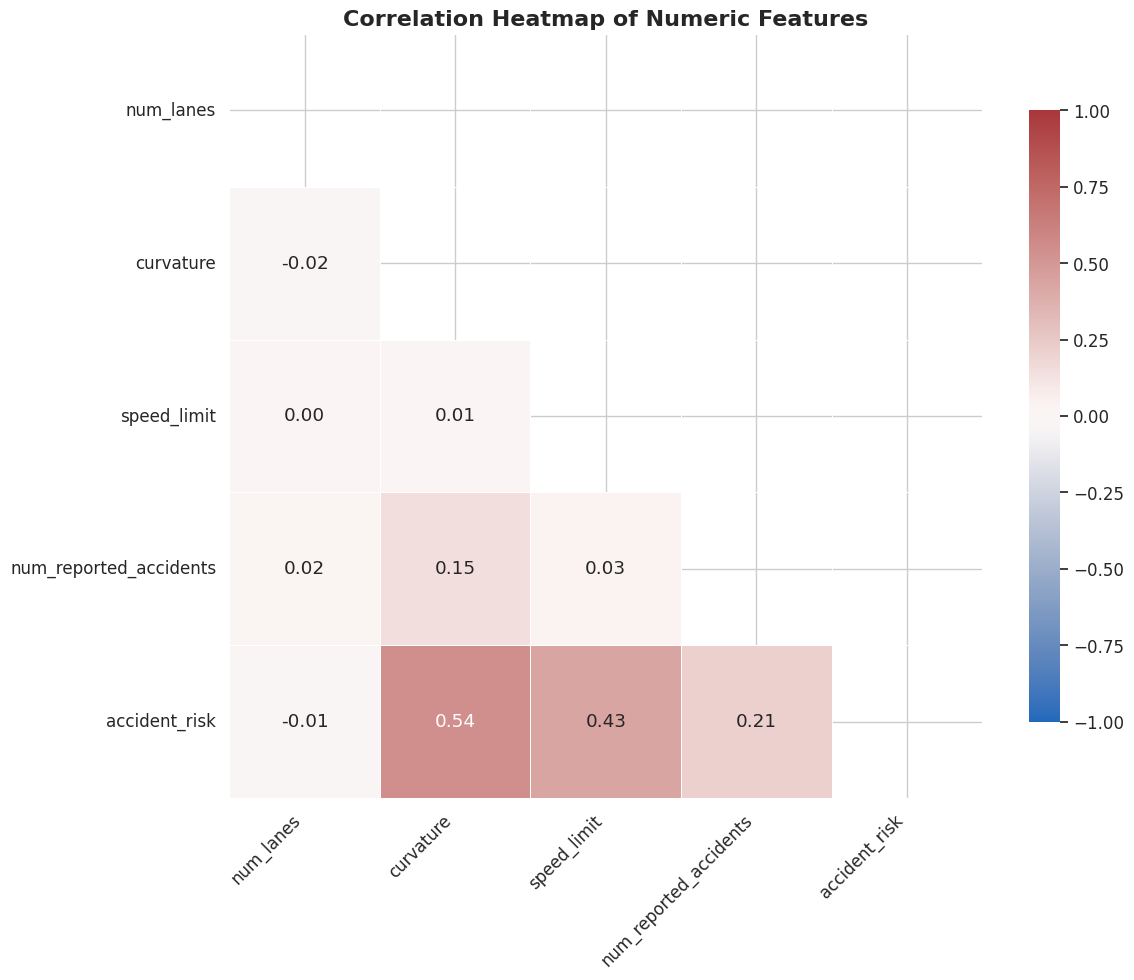

In [18]:
num_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Columns to exclude

exclude_cols = ["id"]
num_features = [col for col in num_features if col not in exclude_cols]

# ==================================
# 5. Enhanced Correlation Analysis
# ==================================


# --- You already have this from the previous step ---
# Assuming 'num_features' is your list of numeric columns
# ---------------------------------------------------

# 1. Calculate the correlation matrix once
corr_matrix = train[num_features].corr()

# 2. Create a mask to hide the redundant upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3. Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# 4. **Expert Tip**: Choose a better diverging colormap and center it
# 'vlag' is a great blue-white-red palette. 'icefire' is another good one.
# Centering at 0 ensures that 0 correlation is neutral (white).
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap="vlag", # A better color palette for correlations
            vmin=-1, vmax=1, # Lock the color scale
            center=0,
            linewidths=.5, # Add lines between cells
            cbar_kws={"shrink": .8}) # Shrink the color bar a bit

plt.title("Correlation Heatmap of Numeric Features", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Key Insights from the Heatmap:

1. Correlations with the Target Variable (accident_risk)

This is the most important part of the analysis for our predictive model. We look at the last row of the heatmap:

👉curvature vs. accident_risk (0.54): This is a moderate positive correlation. It is the strongest relationship we see with the target. This makes intuitive sense: as the curvature of a road increases (i.e., the road becomes less straight), the risk of an accident tends to increase. This is a very promising feature.

👉speed_limit vs. accident_risk (0.43): This is also a moderate positive correlation. As the speed limit on a road increases, the accident risk also tends to rise. This is another strong and logical predictor.

👉num_reported_accidents vs. accident_risk (0.21): There is a weak positive correlation. While positive, this relationship is not as strong as one might initially think, suggesting that accident_risk is not just a simple rescaling of num_reported_accidents and likely incorporates other factors. Nevertheless, as this feature is part of the outcome we want to predict, it still represents a data leakage risk and will be excluded from the model.

👉num_lanes vs. accident_risk (-0.01): There is no linear correlation. This means there is no simple linear trend between the number of lanes and accident risk. This does not mean the feature is useless; its impact could be non-linear or depend on interactions with other features (e.g., a 4-lane highway vs. a 4-lane city street).

2. Inter-Feature Correlations (Checking for Multicollinearity)

We also check for strong correlations between our predictor variables:
The correlations between num_lanes, curvature, and speed_limit are all very close to zero.

Conclusion: This is excellent news! It indicates a lack of multicollinearity among our numerical predictors. Each feature provides independent linear information, which is ideal for most machine learning models and improves model stability and interpretability.

Overall Summary:
The heatmap confirms that curvature and speed_limit are the most important linear predictors for accident_risk among the numerical features. It also reinforces our decision to drop num_reported_accidents and highlights the absence of multicollinearity issues.